## Evaluating generative text models



### Using GPT to generate text

In [4]:
!pip install tiktoken tensorflow>=2.15.0 tqdm>=4.66

In [180]:
# import modules
import tiktoken
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import os
import urllib.request

url = "https://raw.githubusercontent.com/jere-mybao/gpt2/refs/heads/main/04_pretraining/utils.py"
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

from utils import GPTDatasetV1, create_dataloader_v1, MultiHeadAttention, LayerNorm, GELU, FeedForward, TransformerBlock, GPTModel, generate_text_simple

url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

from gpt_download import download_and_load_gpt2

In [6]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256, # reduce from 1024 to allow training on CPU
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1, # it's possible and common to set dropout to 0
    "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval(); #; do not want to return model instance

In [7]:
def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special = {"<|endoftext|>"})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0) # adds the dimension batch
  return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
  flat = token_ids.squeeze(0)
  return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"],
)

print("Output text: \n", token_ids_to_text(token_ids, tokenizer))

Output text: 
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


### Calculating the text generation loss

In [8]:
inputs = torch.tensor([[16833, 3626, 6100], # ["every effort moves",
                       [40,    1107, 588]]) # "I really like"]

In [9]:
targets = torch.tensor([[3626, 6100,  345], # ["effort moves you",
                       [1107, 588, 11311]]) # "really like chocolate"]

In [10]:
with torch.no_grad(): # disables gradient tracking since we are not traking yet
  logits = model(inputs)
probas = torch.softmax(logits, dim=-1) # probability of each token in each vocab
print(probas.shape)

torch.Size([2, 3, 50257])


In [11]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDS: \n", token_ids)

Token IDS: 
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [12]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:"
      f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [13]:
text_idx = 0
target_probas_1 = probas[text_idx, # batch index
                         [0, 1, 2], # grabs 1st, 2nd, 3rd positions
                         targets[text_idx]] # [3626, 6100, 345]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [14]:
log_probas = torch.log(target_probas_1)
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677])


In [15]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.4172)


In [16]:
neg_avg_log_probas = -avg_log_probas
print(neg_avg_log_probas) # cross entropy loss

tensor(10.4172)


In [17]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [18]:
logits_flat = logits.flatten(0, 1) # flattens 1st and 2nd dim into 1
targets_flat = targets.flatten()
print("Logits flat shape:", logits_flat.shape)
print("Targets flat shape:", targets_flat.shape)

Logits flat shape: torch.Size([6, 50257])
Targets flat shape: torch.Size([6])


In [19]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


In [20]:
# more interpretable loss value
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


### Calculating the training and validation set losses


In [138]:
file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [139]:
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [140]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print(f"Total characters: {total_characters}")
print(f"Total tokens: {total_tokens}")

Total characters: 20479
Total tokens: 5145


In [141]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [142]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=False,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [143]:
print("Train loader:")
for x, y in train_loader:
  print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
  print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [144]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


In [145]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

# function to compute the training and validation loss
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader) # iterates over all batches if no fixed num_batches specified
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [147]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad(): # we are not training yet
  # ensure data is loaded onto the same device as the LLM model
  train_loss = calc_loss_loader(train_loader, model, device)
  val_loss = calc_loss_loader(val_loader, model, device)

  print(f"Training loss: {train_loss}")
  print(f"Validation loss: {val_loss}")

Training loss: 10.973814540439182
Validation loss: 10.952580451965332


## Training a LLM

In [29]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval() # dropout is disabled for stable results
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [148]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

In [149]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # main training loop
    for epoch in range(num_epochs):
        model.train()  # set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # calculate loss gradients
            optimizer.step() # update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [150]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(), # returns all trainable weights parameters of the model
    lr=0.0004, weight_decay=0.1
)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.722, Val loss 10.104
Ep 1 (Step 000005): Train loss 7.976, Val loss 8.507
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 2 (Step 000010): Train loss 6.694, Val loss 7.195
Ep 2 (Step 000015): Train loss 5.934, Val loss 6.750
Every effort moves you.                                                 
Ep 3 (Step 000020): Train loss 5.481, Val loss 6.537
Ep 3 (Step 000025): Train loss 5.376, Val loss 6.548
Every effort moves you.                                                 
Ep 4 (Step 000030): Train loss 4.781, Val loss 6.447
Ep 4 (Step 000035): Train loss 4.561, Val loss 6.355
Every effort moves you.                           " I had I had I had he had I had I had a, I had been.   
Ep 5 (Step 000040): Train loss 4.077, Val loss 6.364
Every effort moves you know the fact, and I felt--as he had been a little of his painting, and I was, and in a, and Mrs.                     
Ep 6 (Step 000045): Train loss 3.660, Val loss 6.309
E

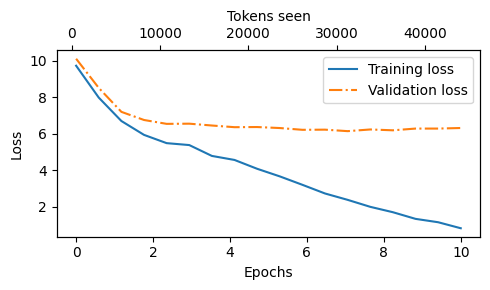

In [151]:
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
  fig, ax1 = plt.subplots(figsize=(5, 3))
  ax1.plot(epochs_seen, train_losses, label="Training loss")
  ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.legend()

  ax2 = ax1.twiny() # creates a second x-axis that shares the same y-axis
  ax2.plot(tokens_seen, train_losses, alpha=0) # invisible plot for aligning ticks
  ax2.set_xlabel("Tokens seen")
  fig.tight_layout()
  plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

# after the second epoch, the model is overfitting to the training data

## Decoding strategies to control randomness

In [153]:
model.to("cpu")
model.eval();

In [154]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size = GPT_CONFIG_124M["context_length"]
)
print("Output text: \n", token_ids_to_text(token_ids, tokenizer))

Output text: 
 Every effort moves you?"

"Yes--quite insensible to the fact with a laugh: "Yes--and by me the fullest reass


### Temperature scaling

In [155]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8
}
inverse_vocab = {v: k for k, v in vocab.items()}

In [66]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [67]:
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[int(next_token_id)])

forward


In [68]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[int(next_token_id)])

toward


In [69]:
def print_sampled_tokens(probas):
  torch.manual_seed(123)
  sample = [torch.multinomial(probas, num_samples=1).item()
           for i in range(1000)]
  sampled_ids = torch.bincount(torch.tensor(sample))
  for i, freq in enumerate(sampled_ids):
    print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


In [71]:
# temperatures > 1: more unfiformly distributed probabilities
# temperatures < 1: more confident distributions
def softmax_with_temperature(logits, temperature):
  scaled_logits = logits / temperature
  return torch.softmax(scaled_logits, dim=0)

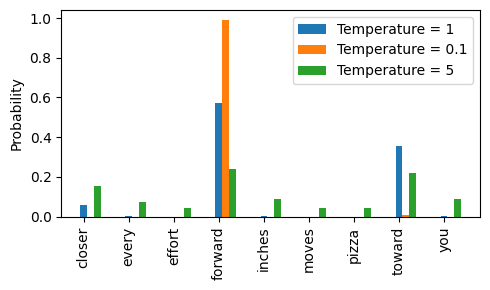

In [72]:
temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T)
                for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
  rects = ax.bar(x + i * bar_width, scaled_probas[i],
                 bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

### Top-k sampling

In [73]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [74]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1], # idenftifies logits less than the min in the top 3
    input=torch.tensor(float('-inf')), # assigns -inf to these lower logits
    other=next_token_logits # retains the original logits for all other tokens
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


### Modifying the text generation function

In [82]:
# a modified text generation function with more diversity
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # new: filter logits with top_k sampling
        if top_k is not None:
            # keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # new: apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [81]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know I bitterness in a to a little it was such a good fellow enough


## Loading and saving model weights in PyTorch

In [86]:
torch.save(model.state_dict(), "model.pth")

In [87]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval();

<ipython-input-87-46bfaa44a014>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth", map_location=device))


In [88]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

In [89]:
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

<ipython-input-89-2e32dcdb1060>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("model_and_optimizer.pth", map_location=device)


## Loading pretrained weights from OpenAI

In [168]:
settings, params = download_and_load_gpt2(
    model_size="124M", models_dir="gpt2"
)

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [169]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [170]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [171]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

In [172]:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

In [173]:
NEW_CONFIG.update({"context_length": 1024})

In [174]:
NEW_CONFIG.update({"qkv_bias": True}) # used in original but not used anymore

In [175]:
gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [176]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [177]:
# loading OpenAI weights into our GPT model code
def load_weights_into_gpt(gpt, params): # sets the model's positional and token embedding weights to those specified in paraams.
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split( # divides the attention and bias weights into three equal parts fo qkv components
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"]) # weight tying

In [178]:
load_weights_into_gpt(gpt, params)
gpt.to(device);

In [179]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you as far as the hand can go until the end of your turn unless something happens

This would remove you from a battle
